In [16]:
import geopandas as gpd
import pandas as pd
import datetime
import utils
import multiprocessing as mp
import itertools
import os
import utils
import matplotlib.pyplot as plt
from tqdm import tqdm

In [14]:
# Environment Variable
FOCUS_SUPPLY = 'ICU_Beds'
# FOCUS_SUPPLY = 'Staffed_Beds'
data = './data'
input_data = os.path.join(data, 'processed_data', 'input_files')
result = os.path.join(data, 'processed_data', 'ICU_access_measures')

## Import input files
### Inputs files with locations

In [5]:
# Supply locations
s_loc = gpd.read_file(os.path.join(input_data, 'hospital_geocode.json'))
s_loc = s_loc.set_index('HC_ID')
s_loc = s_loc.fillna(0)
s_loc

,Type,Zip,County,Staffed_Beds,ICU_Beds,FIPS,TSA,lat,lng,geometry
HC_ID,,,,,,,,,,
H000,Short Term Acute Care Hospital,75001,Dallas,32.0,4,48113,E,32.984766,-96.829405,POINT (1295826.606 1205448.145)
H001,Short Term Acute Care Hospital,75006,Dallas,0.0,0,48113,E,32.986187,-96.898161,POINT (1289408.831 1205423.487)
H002,Short Term Acute Care Hospital,75039,Dallas,80.0,8,48113,E,32.902051,-96.957361,POINT (1284142.861 1195958.149)
H003,Psychiatric Hospital,75042,Dallas,72.0,0,48113,E,32.919345,-96.661640,POINT (1311693.519 1198668.471)
H004,Psychiatric Hospital,75042,Dallas,0.0,0,48113,E,32.913402,-96.670117,POINT (1310922.134 1197986.972)
...,...,...,...,...,...,...,...,...,...,...
H647,Department of Defense Hospital,79920,El Paso,209.0,2,48141,I,31.821613,-106.462489,POINT (389774.009 1090294.335)
H648,Short Term Acute Care Hospital,79928,El Paso,8.0,1,48141,I,31.681737,-106.208044,POINT (412906.494 1073465.365)
H649,Rehabilitation Hospital,79936,El Paso,41.0,0,48141,I,31.732221,-106.303061,POINT (404248.394 1079550.379)


In [27]:
# Demand locations
d_loc = gpd.read_file(os.path.join(data, 'original_data', 'demand_related', 'tl_2019_48_tract', 'tl_2019_48_tract_epsg_3081.shp'))
d_loc = d_loc.set_index('GEOID')
d_loc

,geometry
GEOID,
48439121609,"POLYGON ((1258979.722 1169792.438, 1258982.386..."
48187210708,"POLYGON ((1168044.841 825633.988, 1168062.377 ..."
48201550301,"POLYGON ((1439359.176 877889.870, 1439375.495 ..."
48201550302,"POLYGON ((1436698.365 880665.773, 1437130.118 ..."
48157675800,"POLYGON ((1378127.932 833537.067, 1378446.964 ..."
...,...
48167720501,"POLYGON ((1467815.137 824783.412, 1467947.193 ..."
48167721202,"POLYGON ((1476434.369 825589.518, 1476482.737 ..."
48167722002,"POLYGON ((1490432.310 815434.091, 1490431.192 ..."


In [7]:
# Mobility: OD Matrix between supply and demand locations
mobility_df = pd.read_csv(os.path.join(input_data, 'Precalculated_OD_Matrix.csv'))
mobility_df

,HC_ID,GEOID,trvl_time
0,H000,48439121609,39.038224
1,H000,48251130208,52.587246
2,H000,48251131000,65.449505
3,H000,48251131100,64.276180
4,H000,48251130409,54.061421
...,...,...,...
442433,H651,48141003403,10.521284
442434,H651,48141003404,9.035687
442435,H651,48141003502,11.671903
442436,H651,48141003602,14.517034


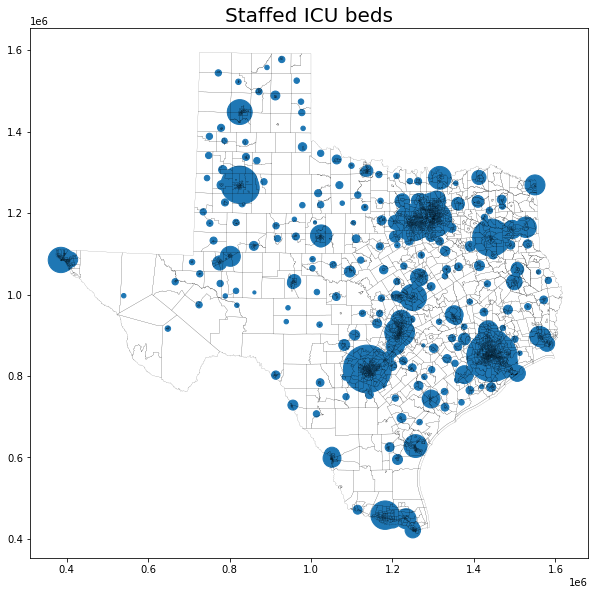

In [8]:
# Geographical distribution of inputs variables
fig, ax = plt.subplots(figsize=(10, 10))

s_loc.plot(ax=ax, markersize=s_loc['ICU_Beds']*10)
d_loc.boundary.plot(ax=ax, lw=0.1, color='black')
ax.set_title('Staffed ICU beds', fontsize=20)

plt.show()

### Input files about temporal variations

In [9]:
# Supply daily variation
s_val = pd.read_csv(os.path.join(input_data, 'ICU_beds_available_ratio.csv'))
s_val = s_val.rename(columns={'Unnamed: 0': 'TSA'})
s_val = s_val.set_index('TSA')
s_val

,06/01/2020,06/02/2020,06/03/2020,06/04/2020,06/05/2020,06/06/2020,06/07/2020,06/08/2020,06/09/2020,06/10/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
TSA,,,,,,,,,,,,,,,,,,,,,
A,0.299130,0.297071,0.293083,0.303644,0.304791,0.301619,0.304040,0.308157,0.320641,0.332673,...,0.079110,0.081352,0.086207,0.087331,0.091352,0.085749,0.081535,0.080668,0.079602,0.066946
B,0.188489,0.184241,0.190338,0.198499,0.195041,0.208866,0.238261,0.241470,0.246935,0.245599,...,0.090835,0.082651,0.077176,0.069959,0.059701,0.047225,0.050654,0.048250,0.048152,0.044199
C,0.443750,0.455000,0.415771,0.398734,0.396825,0.388715,0.366460,0.363636,0.352239,0.366667,...,0.037975,0.025478,0.037037,0.066265,0.063953,0.072222,0.064865,0.074534,0.087591,0.073394
D,0.385057,0.384956,0.396491,0.401760,0.400000,0.407202,0.417582,0.405405,0.388102,0.389356,...,0.081851,0.088339,0.083916,0.071429,0.066445,0.055738,0.039867,0.026923,0.013699,0.011429
E,0.272063,0.269432,0.265481,0.264746,0.261220,0.256144,0.247004,0.241160,0.234618,0.235317,...,0.072909,0.072154,0.067877,0.065986,0.063651,0.060885,0.056968,0.055642,0.053312,0.051334
F,0.655797,0.659452,0.666667,0.669715,0.675050,0.670286,0.664688,0.661149,0.654179,0.647059,...,0.204225,0.230588,0.217494,0.202410,0.217184,0.217890,0.199105,0.189258,0.169184,0.180812
G,0.298762,0.294190,0.292708,0.283615,0.284055,0.284626,0.277903,0.272025,0.268527,0.267133,...,0.135796,0.134555,0.132878,0.130915,0.128219,0.120400,0.114076,0.107599,0.102174,0.096223
H,0.236749,0.238636,0.236277,0.231557,0.230928,0.230769,0.209979,0.192389,0.173362,0.162105,...,0.115646,0.110000,0.120915,0.147436,0.152104,0.143813,0.139373,0.135802,0.130000,0.103448
I,0.160542,0.159969,0.160359,0.162740,0.161308,0.163043,0.158207,0.155051,0.158262,0.165422,...,0.017732,0.015866,0.012218,0.010437,0.008517,0.008052,0.007081,0.007075,0.007047,0.007018


In [10]:
# Demand daily variation
d_val = pd.read_csv(os.path.join(input_data, 'estimated_covid_case.csv'))
d_val = d_val.set_index('GEOID')
d_val = d_val.drop(columns=['FIPS', 'CTID', 'Pop_Ratio', 'County_Pop'])
d_val

,Tract_Pop,06/01/2020,06/02/2020,06/03/2020,06/04/2020,06/05/2020,06/06/2020,06/07/2020,06/08/2020,06/09/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
GEOID,,,,,,,,,,,,,,,,,,,,,
48001950100,4844,2.295139,4.983178,4.635861,5.782551,6.321416,6.237121,6.102300,6.076660,6.327365,...,3.193303,3.474843,3.428925,3.811518,3.861374,4.249581,4.389849,5.296056,5.465902,5.656361
48001950401,4838,2.292296,4.977006,4.630119,5.775389,6.313586,6.229396,6.094742,6.069133,6.319528,...,3.189348,3.470539,3.424678,3.806797,3.856591,4.244318,4.384411,5.289496,5.459132,5.649355
48001950402,7511,3.558793,7.726806,7.188265,8.966297,9.801849,9.671143,9.462093,9.422336,9.811073,...,4.951465,5.388015,5.316816,5.910057,5.987362,6.589308,6.806803,8.211949,8.475308,8.770629
48001950500,4465,2.115565,4.593289,4.273146,5.330118,5.826821,5.749122,5.624850,5.601215,5.832305,...,2.943455,3.202967,3.160642,3.513301,3.559256,3.917089,4.046382,4.881687,5.038244,5.213801
48001950600,5148,2.439178,5.295913,4.926799,6.145453,6.718136,6.628551,6.485269,6.458020,6.724458,...,3.393708,3.692917,3.644118,4.050722,4.103707,4.516277,4.665347,5.628427,5.808932,6.011343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48505950400,5399,1.121017,1.483744,1.456945,1.416181,1.362961,1.680393,1.623776,1.577350,1.544513,...,3.539319,3.066001,3.024104,3.034673,3.489496,3.250195,5.332947,5.200463,5.097043,5.012872
48507950100,1448,0.021529,0.009261,0.003488,0.120997,0.120276,0.120276,0.120276,0.120276,0.240552,...,2.324931,2.307250,2.522423,2.366426,2.209105,2.307250,2.191545,2.345738,2.404072,2.590018
48507950200,1608,0.023908,0.010285,0.003873,0.134367,0.133566,0.133566,0.133566,0.133566,0.267132,...,2.581829,2.562195,2.801144,2.627909,2.453205,2.562195,2.433704,2.604936,2.669715,2.876208


## Focus date of analysis

In [11]:
# Focus dates of analysis
from_date = '2020-06-01'
to_date = '2021-12-31'

start_date = datetime.datetime.strptime(from_date,  "%Y-%m-%d")
end_date = datetime.datetime.strptime(to_date,  "%Y-%m-%d")

focus_date = []
delta = datetime.timedelta(days=1)
while start_date <= end_date:
    focus_date.append(start_date.strftime("%m/%d/%Y"))
    start_date += delta
    

## Accessibility Measurement

In [ ]:
# # Following cell was run on Keeling due to multiprocessing capability (see 'ICU_Accessibility_Measurements.py'). 
# # Keeling will save the file in 'data/processed_data/ICU_acc_measures'
# # `acc_step1_{date}.csv` is the step 1 of E2SFCA method on `date`
# # `acc_step2_{date}.csv` is the step 2 of E2SFCA method on `date`

# if __name__ == "__main__":
#     pool = mp.Pool(8)
#     pool.map(utils.measure_accessibility_unpacker,
#              zip(itertools.repeat(s_loc),
#                  itertools.repeat(d_loc),
#                  itertools.repeat(s_val),
#                  itertools.repeat(d_val),
#                  itertools.repeat(mobility_df),
#                  focus_date,
#                  itertools.repeat(FOCUS_SUPPLY))
#              )
#     pool.close()


## Combine daily access measurements to a single file

In [28]:
acc = d_loc.copy(deep=True)

for date in tqdm(focus_date):
    date_ = date.replace('/', '_')
    temp_result = pd.read_csv(os.path.join(result, 'keeling', f'acc_step2_{date_}.csv'))
    temp_result['GEOID'] = temp_result['GEOID'].astype(str)
    temp_result = temp_result.set_index('GEOID')
    acc = acc.merge(temp_result, left_index=True, right_index=True)
    
acc

100%|██████████| 579/579 [00:15<00:00, 38.39it/s]


,geometry,06/01/2020,06/02/2020,06/03/2020,06/04/2020,06/05/2020,06/06/2020,06/07/2020,06/08/2020,06/09/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
GEOID,,,,,,,,,,,,,,,,,,,,,
48439121609,"POLYGON ((1258979.722 1169792.438, 1258982.386...",0.161680,0.165527,0.165790,0.102217,0.092232,0.089481,0.087822,0.084158,0.071822,...,0.009855,0.009524,0.008484,0.007499,0.007019,0.006015,0.005198,0.004867,0.004332,0.003849
48187210708,"POLYGON ((1168044.841 825633.988, 1168062.377 ...",0.288999,0.270802,0.262718,0.189898,0.163777,0.160656,0.158163,0.146355,0.129688,...,0.011228,0.011050,0.010220,0.008852,0.008359,0.007456,0.006754,0.006208,0.005578,0.005091
48201550301,"POLYGON ((1439359.176 877889.870, 1439375.495 ...",0.028989,0.028079,0.028518,0.024990,0.023766,0.023730,0.024537,0.023845,0.021591,...,0.005220,0.004680,0.004106,0.003591,0.003323,0.002947,0.002915,0.002672,0.002500,0.002367
48201550302,"POLYGON ((1436698.365 880665.773, 1437130.118 ...",0.028175,0.027279,0.027705,0.024281,0.023097,0.023063,0.023846,0.023170,0.020980,...,0.005076,0.004551,0.003994,0.003494,0.003233,0.002867,0.002835,0.002599,0.002431,0.002301
48157675800,"POLYGON ((1378127.932 833537.067, 1378446.964 ...",0.059121,0.046625,0.042381,0.026221,0.023914,0.023062,0.022810,0.020996,0.017840,...,0.004653,0.004240,0.003713,0.003213,0.003033,0.002723,0.002611,0.002341,0.002222,0.002037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48167720501,"POLYGON ((1467815.137 824783.412, 1467947.193 ...",0.021362,0.020953,0.021397,0.018569,0.017554,0.017511,0.018163,0.017784,0.016100,...,0.003972,0.003568,0.003126,0.002727,0.002516,0.002224,0.002180,0.001992,0.001863,0.001767
48167721202,"POLYGON ((1476434.369 825589.518, 1476482.737 ...",0.017263,0.016946,0.017347,0.015042,0.014231,0.014202,0.014734,0.014462,0.013088,...,0.003295,0.002961,0.002600,0.002279,0.002100,0.001852,0.001805,0.001647,0.001538,0.001452
48167722002,"POLYGON ((1490432.310 815434.091, 1490431.192 ...",0.014618,0.014359,0.014798,0.012795,0.012137,0.012125,0.012587,0.012433,0.011242,...,0.002989,0.002688,0.002373,0.002106,0.001934,0.001695,0.001627,0.001481,0.001376,0.001283


In [20]:
acc.to_file(os.path.join(result, 'ICU_access_tract.shp'))

## Aggregate Census Tract level accessiblity to County level

In [40]:
# Load population ratio of each census tract from its county 
pop_ratio = pd.read_csv(os.path.join(input_data, 'estimated_covid_case.csv'))
pop_ratio['GEOID'] = pop_ratio['GEOID'].astype(str)
pop_ratio = pop_ratio.set_index('GEOID')
pop_ratio = pop_ratio['Pop_Ratio']
pop_ratio = pop_ratio.sort_index()
pop_ratio

GEOID
48001950100    0.083792
48001950401    0.083688
48001950402    0.129926
48001950500    0.077236
48001950600    0.089050
                 ...   
48505950400    0.377447
48507950100    0.120276
48507950200    0.133566
48507950301    0.173187
48507950302    0.572971
Name: Pop_Ratio, Length: 5265, dtype: float64

In [44]:
# Aggregate accessibility measures of census tracts into counties 
# based on the population ratio of each census tract over the counties.  
county = gpd.read_file(os.path.join(data, 'original_data', 'demand_related', 'tl_2021_48_county', 'tl_2021_48_county.shp'))
county = county[['GEOID', 'NAME', 'geometry']]
county = county.set_index('GEOID')

acc_county = county.copy(deep=True)

for date in tqdm(focus_date):
    temp_county = pd.DataFrame(pop_ratio.index)
    temp_county['County'] = temp_county.apply(lambda x:str(x['GEOID'])[0:5], axis=1)
    temp_county = temp_county.set_index('GEOID')
    
    temp_county[date] = acc[date] * pop_ratio
    temp_county = temp_county.groupby('County').sum()
    temp_county.index = temp_county.index.astype(str)
    
    acc_county = acc_county.merge(temp_county, left_index=True, right_index=True)
    
acc_county

100%|██████████| 579/579 [00:34<00:00, 16.62it/s]


,NAME,geometry,06/01/2020,06/02/2020,06/03/2020,06/04/2020,06/05/2020,06/06/2020,06/07/2020,06/08/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
48327,Menard,"POLYGON ((-99.77120 30.71079, -99.78240 30.710...",0.481450,0.504673,0.494921,0.359804,0.380861,0.416848,0.445366,0.463968,...,0.054528,0.057078,0.055447,0.057775,0.058969,0.056747,0.050579,0.046795,0.044798,0.042296
48189,Hale,"POLYGON ((-101.73504 33.82864, -101.73507 33.8...",2.661175,2.398550,2.288703,0.672046,0.550668,0.580442,0.673039,0.691939,...,0.008098,0.007549,0.006805,0.006247,0.005544,0.004431,0.004738,0.004571,0.004513,0.003913
48011,Armstrong,"POLYGON ((-101.08728 35.02708, -101.08729 35.0...",0.008839,0.008874,0.009701,0.009687,0.008540,0.009005,0.009563,0.009912,...,0.001544,0.001716,0.001967,0.002158,0.002462,0.002360,0.002270,0.002396,0.002478,0.002131
48057,Calhoun,"POLYGON ((-96.35229 28.50953, -96.35241 28.508...",2.364419,1.663282,1.490708,0.618558,0.560262,0.519041,0.482546,0.417936,...,0.145849,0.138889,0.120955,0.109047,0.109674,0.100102,0.084663,0.076442,0.073078,0.062078
48077,Clay,"POLYGON ((-97.97784 33.81417, -97.97784 33.813...",1.756416,1.993939,1.554681,0.504286,0.399408,0.381449,0.362439,0.333911,...,0.002441,0.001702,0.002336,0.003988,0.003731,0.004190,0.003748,0.004242,0.005163,0.004003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48205,Hartley,"POLYGON ((-102.31929 36.05545, -102.31679 36.0...",0.006707,0.005750,0.004902,0.004558,0.004376,0.004434,0.004598,0.004674,...,0.001734,0.001811,0.001831,0.001935,0.002155,0.002174,0.001744,0.001722,0.001556,0.001319
48249,Jim Wells,"POLYGON ((-97.93395 27.85971, -97.93395 27.859...",0.088138,0.079848,0.083542,0.071925,0.067427,0.058720,0.055637,0.047810,...,0.014499,0.015263,0.015418,0.013864,0.013206,0.011861,0.010291,0.009210,0.008283,0.006693
48505,Zapata,"POLYGON ((-99.15217 27.27142, -99.15088 27.271...",0.016376,0.015432,0.014533,0.013183,0.011311,0.010970,0.010990,0.010499,...,0.000955,0.000811,0.000611,0.000517,0.000439,0.000386,0.000347,0.000323,0.000289,0.000243
48453,Travis,"POLYGON ((-97.76561 30.43241, -97.76532 30.432...",0.992614,0.944165,0.902917,0.317952,0.267939,0.253893,0.249922,0.242535,...,0.013435,0.011647,0.010643,0.008338,0.007260,0.006277,0.005383,0.004461,0.003922,0.003542


In [45]:
acc_county.to_file(os.path.join(result, 'ICU_access_county.shp'))

/Users/zawoon96/opt/anaconda3/envs/sa/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
